In [226]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../src')

from dataset import DatasetConfig, DatasetBuilder
from geometry import Rays
import os
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from collections import defaultdict
from typing import Callable, Dict, List, Tuple
%matplotlib inline

plt.rcParams["figure.figsize"] = (12, 12)

In [901]:
ds_config =  DatasetConfig(model_dir='../dataset/pinecone/sparse/0/',
                           images_dir='../dataset/pinecone/images/',
                           batch_from_single_image=True,
                           batch_size=64)
dataset_builder = DatasetBuilder(ds_config)
train_ds = dataset_builder.build_train_dataset()

In [902]:
rays = []

for elements in train_ds.take(1).as_numpy_iterator():
    rays.append(elements)

In [341]:
from flax import linen as nn
import jax.numpy as jnp
from jax import vmap

In [9]:
class Model(nn.Module):
    """A simple CNN model."""

    @nn.compact
    def __call__(self, rays):
        return x
    

In [990]:
from jax import random, jit

from functools import partial

EPS = 1e-5

def sample_pdf(rng, bins, weights, num_samples, is_random=False):
    weights += EPS
    pdf = weights / jnp.sum(weights, axis=-1, keepdims=True)
    cdf = jnp.cumsum(pdf, axis=-1)
    cdf = jnp.concatenate([jnp.zeros_like(cdf[..., :1]), cdf], axis=-1)

    if is_random:
        u = random.uniform(rng, (num_samples,))
    else:
        u = jnp.linspace(0.0, 1.0, num_samples)

    index_higher = jnp.searchsorted(cdf, u, side='right')
    index_lower = jnp.maximum(0, index_higher - 1)

    cdf_higher = cdf[index_higher]
    cdf_lower = cdf[index_lower]

    cdf_span = cdf_higher - cdf_lower
    cdf_span = jnp.where(cdf_span < EPS, 1.0, cdf_span)
    slope = (u - cdf_lower) / cdf_span
    
    bin_span = bins[index_higher] - bins[index_lower]
    sampled_values = bins[index_lower] + slope * bin_span
    return sampled_values


def sample_along_rays(rng: jnp.ndarray, rays: Rays, all_bins, all_weights, num_samples: int, is_random: bool = False) -> jnp.ndarray:
    
    def sample_helper(rng, origin, direction, bins, weights):
        z_samples = sample_pdf(rng, bins, weights, num_samples, is_random)
        direction = z_samples[..., jnp.newaxis] * direction[jnp.newaxis, :]
        points = origin[jnp.newaxis, :] + direction
        return points

    num_rays = rays.origins.shape[0]
    rngs = random.split(rng, num_rays)
    points = vmap(sample_helper)(rngs, rays.origins, rays.directions, all_bins, all_weights)
    return points

rays = Rays(elements[0], elements[1], elements[2])
rng = random.PRNGKey(0)

num_rays = rays.origins.shape[0]
num_samples = 5000

num_bins = 1000
near = 1
far = 100
bins = jnp.linspace(near, far, num_bins)

get_weights = lambda m: jnp.exp(-0.5 * jnp.square((bins - m) / 2)) + jnp.exp(-0.5 * jnp.square((bins - m - 10) / 5))
centers = jnp.linspace(20, 80, num_rays, dtype=jnp.float32)[::-1]
weights = vmap(get_weights)(centers)

bins = jnp.broadcast_to(bins, (num_rays, num_bins))


# num_rays = rays.origins.shape[0]
# num_bins = 1000
# bins = jnp.linspace(near, far, num_bins)
# bins = jnp.broadcast_to(bins, (num_rays, num_bins))
# weights = jnp.ones_like(bins)

def sample_along_rays(rng: jnp.ndarray, rays: Rays, near, far, num_samples: int, randomized: bool = False) -> jnp.ndarray:
    if randomized:
        z_samples = random.uniform(rng, (num_samples, ), minval=near, maxval=far)
    else:
        z_samples = jnp.linspace(near, far, num_samples)

    directions = z_samples * rays.directions[..., jnp.newaxis]
    points = rays.origins[..., jnp.newaxis] + directions
    return points


sampler_fn = jit(partial(sample_along_rays,
                                   near=near,
                                   far=far,
                                   num_samples=num_samples,
                                   randomized=True))

%timeit points = sampler_fn(rng, rays)

341 µs ± 610 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [955]:
points.shape

(64, 3, 5000)

Text(0.5, 1.0, 'Sampled Distribution')

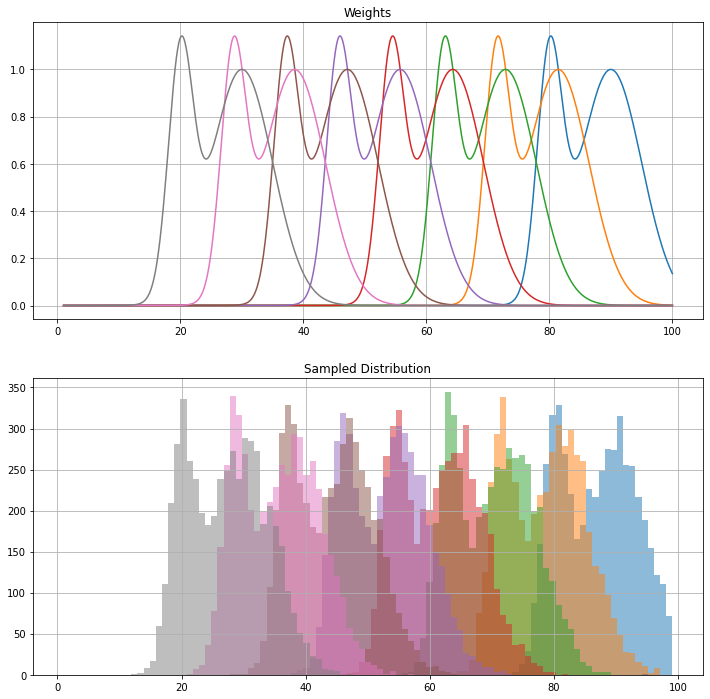

In [896]:
ax = plt.subplot(211)
for i in range(8):
    ax.plot(bins[i], weights[i])
ax.grid("on")
ax.set_title("Weights")

ax = plt.subplot(212)
for i in range(8):
    _ = ax.hist(jnp.linalg.norm(points[i] - rays.origins[i], axis=-1), bins[i][::10], alpha=0.5)
ax.grid("on")
ax.set_title("Sampled Distribution")

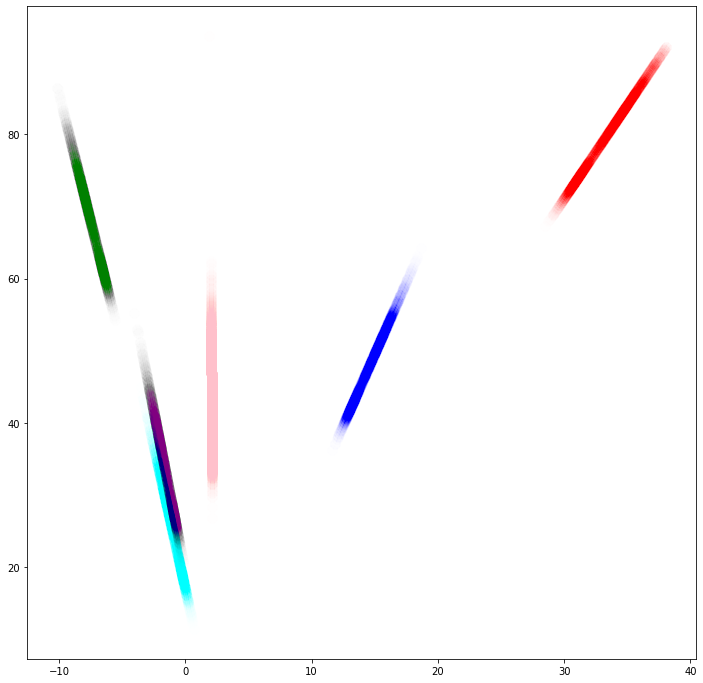

In [897]:
alpha=0.005

i = 0
x = points[i, ..., 0]
y = points[i, ..., 1]
z = points[i, ..., 2]
plt.scatter(x, z, s=100, color="red", alpha=alpha)

i = 2
x = points[i, ..., 0]
y = points[i, ..., 1]
z = points[i, ..., 2]
plt.scatter(x, z, s=100, color="green", alpha=alpha)

i = 3
x = points[i, ..., 0]
y = points[i, ..., 1]
z = points[i, ..., 2]
plt.scatter(x, z, s=100, color="blue", alpha=alpha)

i = 5
x = points[i, ..., 0]
y = points[i, ..., 1]
z = points[i, ..., 2]
plt.scatter(x, z, s=100, color="pink", alpha=alpha)

i = 6
x = points[i, ..., 0]
y = points[i, ..., 1]
z = points[i, ..., 2]
plt.scatter(x, z, s=100, color="purple", alpha=alpha)

i = 7
x = points[i, ..., 0]
y = points[i, ..., 1]
z = points[i, ..., 2]
plt.scatter(x, z, s=100, color="cyan", alpha=alpha)

In [854]:
views = jnp.broadcast_to(rays.directions[:, jnp.newaxis, :], points.shape)
views.shape

(8, 5000, 3)

In [858]:
views[0]

(5000, 3)

In [857]:
rays.directions

array([[ 0.35822025, -0.07059386,  0.9309573 ],
       [ 0.479604  , -0.13443677,  0.8671186 ],
       [-0.13947505, -0.10665706,  0.9844559 ],
       [ 0.20156561, -0.5644826 ,  0.80044574],
       [ 0.35279506,  0.04662992,  0.9345315 ],
       [-0.00354181, -0.07558354,  0.99712485],
       [-0.11103202,  0.05490232,  0.99229115],
       [-0.12393689, -0.13990475,  0.9823688 ]], dtype=float32)

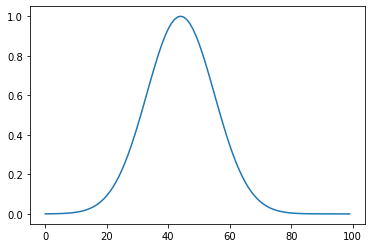

In [174]:
plt.plot(weights)

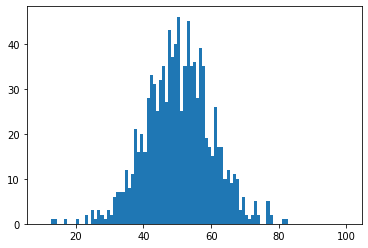

In [188]:
_ = plt.hist(z_samples, bins)